# Task 3

## Task 3.1

In [3]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
import matplotlib.pyplot as plt
from dataclasses import dataclass
import torch.nn.functional as F

In [4]:
########################
# Model definition:
########################

from model.gaot import GAOT
from model.layers.magno import MAGNOConfig
from model.layers.attn import TransformerConfig


# Configuration dataclass
@dataclass
class ModelArgs:
    magno: MAGNOConfig
    transformer: TransformerConfig


@dataclass
class GAOTConfig:
    latent_tokens_size: list
    args: ModelArgs


# Create configuration based on user requirements
magno_config = MAGNOConfig(
    coord_dim=2,
    radius=0.033,
    hidden_size=64,
    mlp_layers=3,
    lifting_channels=64
)

transformer_config = TransformerConfig(
    patch_size=2,
    hidden_size=256
)

model_args = ModelArgs(
    magno=magno_config,
    transformer=transformer_config
)

config = GAOTConfig(
    latent_tokens_size=[64, 64],
    args=model_args
)


# Create coordinate grid for 64x64 regular grid
def create_coordinate_grid(height=64, width=64):
    """
    Create a regular 2D coordinate grid.

    Returns:
        coords: torch.Tensor of shape [height*width, 2]
                Coordinates normalized to [0, 1] x [0, 1]
    """
    y = torch.linspace(-1, 1, height)
    x = torch.linspace(-1, 1, width)

    grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')

    # Flatten and stack to get [N, 2] coordinates
    coords = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

    return coords


# Create coordinate grids (fixed for all samples)
coord_grid = create_coordinate_grid(64, 64)
latent_tokens_coord = create_coordinate_grid(64, 64)

# Initialize GAOT model
model = GAOT(
    input_size=1,  # input has 1 channel
    output_size=1,  # output has 1 channel
    config=config
)

print(f"Model initialized: GAOT")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Using torch_cluster for efficient neighbor search
Using torch_cluster for efficient neighbor search
Model initialized: GAOT
Number of parameters: 3396033


In [5]:
import torch
from torch.utils.data import Dataset
import xarray as xr

class ElasticityDataset(Dataset):
    def __init__(self, path, split="train", train_ratio=0.9):
        super().__init__()

        # Use engine="h5netcdf" or "netcdf4"
        ds = xr.open_dataset(path)

        # 1. Extract and Squeeze the data
        inputs_c = ds["c"].values.squeeze() 
        outputs_u = ds["u"].values.squeeze()
        coords_x = ds["x"].values.squeeze()

        n_samples = inputs_c.shape[0]
        n_train = int(train_ratio * n_samples)

        if split == "train":
            self.c = inputs_c[:n_train]
            self.u = outputs_u[:n_train]
            self.x = coords_x[:n_train]
        elif split == "val":
            self.c = inputs_c[n_train:]
            self.u = outputs_u[n_train:]
            self.x = coords_x[n_train:]
        else:
            raise ValueError("split must be 'train' or 'val'")
        
        # Convert to float32 tensors
        self.c = torch.tensor(self.c, dtype=torch.float32)
        self.u = torch.tensor(self.u, dtype=torch.float32)
        self.x = torch.tensor(self.x, dtype=torch.float32)

    def __len__(self):
        return self.c.shape[0]

    def __getitem__(self, idx):
        # Return a dictionary or a tuple. 
        # Most models for this data (like DeepONet or GNO) 
        # require the values 'c' and the coordinates 'x'.
        return {
            "input": self.c[idx], 
            "coords": self.x[idx], 
            "output": self.u[idx],
        }

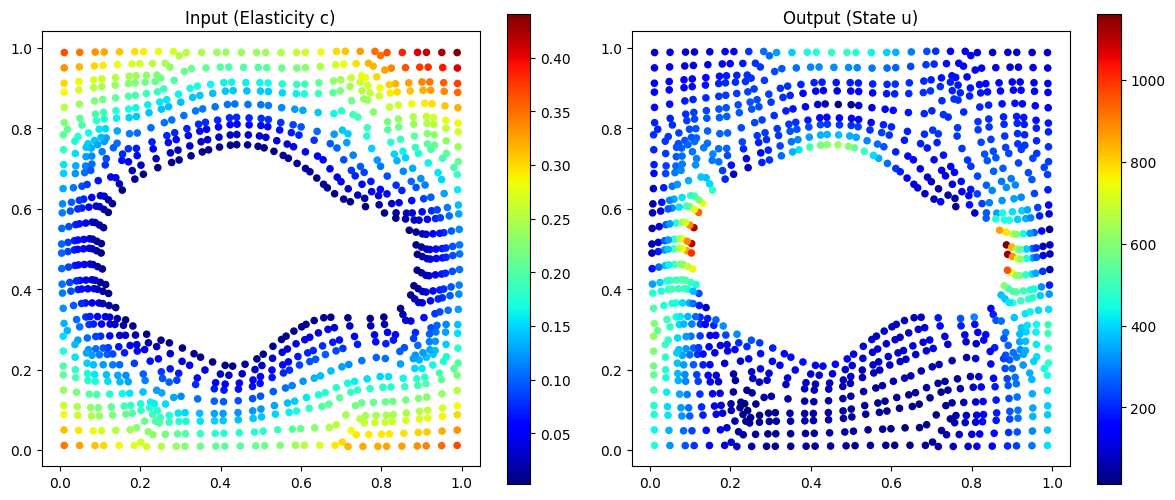

In [ ]:
training_samples = 256
batch_size = 16

train_dataset = ElasticityDataset(path="data/Elasticity.nc",split="train")
val_dataset = ElasticityDataset(path="data/Elasticity.nc",split="val")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

batch = next(iter(train_loader))
# Indices: [0] for first sample in batch, then convert to numpy
coords = batch["coords"][0].numpy()
input = batch["input"][0].numpy()
output = batch["output"][0].numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Input (Elasticity 'c')
im1 = axes[0].scatter(coords[:, 0], coords[:, 1], c=input, cmap="jet", s=20)
axes[0].set_title("Input (Elasticity c)")
axes[0].set_aspect('equal')
fig.colorbar(im1, ax=axes[0])

# Plot Output (State 'u')
im2 = axes[1].scatter(coords[:, 0], coords[:, 1], c=output, cmap="jet", s=20)
axes[1].set_title("Output (State u)")
axes[1].set_aspect('equal')
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


### Training loop

In [7]:
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=200, eta_min=10**-6)
l = torch.nn.L1Loss()

num_epochs = 20

freq_print = 1
for epoch in range(num_epochs):
    model.train()
    train_mse = 0.0
    for step, (batch) in enumerate(train_loader):
        coords = batch["coords"][0]
        input = batch["input"].unsqueeze(-1)
        output = batch["output"].unsqueeze(-1)

        optimizer.zero_grad()

        # Forward pass through GAOT
        # In fx mode (fixed coordinates), xcoord and latent_tokens_coord don't need batch dimension
        pred = model(
            latent_tokens_coord=latent_tokens_coord,  # [N, 2]
            xcoord=coords,  # [N, 2]
            pndata=input,  # [batch, N, 1]
            query_coord=None,  # Use xcoord as query
            encoder_nbrs=None,  # Compute neighbors on-the-fly
            decoder_nbrs=None,
            condition=None
        )

        # Compute loss
        loss_f = l(pred, output) / l(output, torch.zeros_like(output))
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(train_loader)

    scheduler.step()
    with torch.no_grad():
        model.eval()
        test_relative_l1 = 0.0
        for step, (batch) in enumerate(val_loader):

            coords = batch["coords"][0]
            input = batch["input"].unsqueeze(-1)
            output = batch["output"].unsqueeze(-1)

            pred = model(
                latent_tokens_coord=latent_tokens_coord,
                xcoord=coords,
                pndata=input,
                query_coord=None,
                encoder_nbrs=None,
                decoder_nbrs=None,
                condition=None
            )

            loss_f = (torch.mean((abs(pred - output))) / torch.mean(abs(output))) * 100
            test_relative_l1 += loss_f.item()
        test_relative_l1 /= len(val_loader)

    if epoch % freq_print == 0:
        print("## Epoch:", epoch, " ## Train Loss:", train_mse, "## Rel L1 Test Norm:", test_relative_l1, "LR: ", scheduler.get_last_lr())


## Epoch: 0  ## Train Loss: 0.478282219672625 ## Rel L1 Test Norm: 26.1919306241549 LR:  [0.0009999383779245895]
## Epoch: 1  ## Train Loss: 0.23809680672345962 ## Rel L1 Test Norm: 21.622510763315056 LR:  [0.0009997535269026829]
## Epoch: 2  ## Train Loss: 0.20958563685417175 ## Rel L1 Test Norm: 19.43225860595703 LR:  [0.000999445492543504]
## Epoch: 3  ## Train Loss: 0.174903675386336 ## Rel L1 Test Norm: 15.776635243342472 LR:  [0.0009990143508499217]
## Epoch: 4  ## Train Loss: 0.15656070740876998 ## Rel L1 Test Norm: 13.495781825138973 LR:  [0.0009984602081996976]
## Epoch: 5  ## Train Loss: 0.1390416323479298 ## Rel L1 Test Norm: 12.495673986581656 LR:  [0.0009977832013192385]
## Epoch: 6  ## Train Loss: 0.12741358795788435 ## Rel L1 Test Norm: 11.492777310884916 LR:  [0.0009969834972498623]
## Epoch: 7  ## Train Loss: 0.11905122699990736 ## Rel L1 Test Norm: 10.746713198148287 LR:  [0.0009960612933065818]
## Epoch: 8  ## Train Loss: 0.11368560744861586 ## Rel L1 Test Norm: 10.4

# Plot results

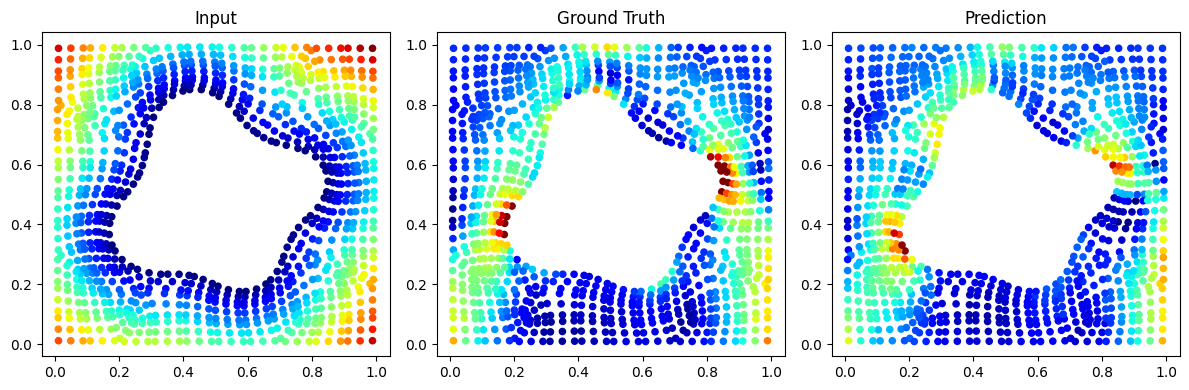

In [20]:
model.eval()
with torch.no_grad():
    batch = next(iter(val_loader))

    # Reshape for GAOT model
    coords = batch["coords"][0:1]
    input = batch["input"][0:1].unsqueeze(-1)
    output = batch["output"][0:1].unsqueeze(-1)

    pred = model(
                latent_tokens_coord=latent_tokens_coord,
                xcoord=coords,
                pndata=input,
                query_coord=None,
                encoder_nbrs=None,
                decoder_nbrs=None,
                condition=None
            )

    # Reshape back to image format
    # pred = pred.reshape(batch_size, 1, 64, 64)

    # Convert to numpy for visualization
    coords = coords.squeeze(0).numpy()
    input = input.squeeze().numpy()
    output = output.squeeze().numpy()
    pred = pred.squeeze().numpy()

vmin, vmax = pred.min(), pred.max()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].scatter(coords[:, 0], coords[:, 1], c=input, cmap="jet", s=20)
axes[0].set_title("Input")

axes[1].scatter(coords[:, 0], coords[:, 1], c=output, cmap="jet", s=20, vmin=vmin, vmax=vmax)
axes[1].set_title("Ground Truth")

axes[2].scatter(coords[:, 0], coords[:, 1], c=pred, cmap="jet", s=20, vmin=vmin, vmax=vmax)
axes[2].set_title("Prediction")
plt.tight_layout()
plt.show()

## Task 3.2